In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma, factorial

STARTING_RANGE_PARAMETER = 0.1 # In [fm^-2]
ENDING_RANGE_PARAMETER = 25
BETA = 0.0000001 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 30 # Determines the number of gaussians we expand our wave function to
CORE_MS_RADIUS = 2.30**2 # In fm^2, taken from p.232 of Tanihata et. al. (2013)

V_LS = 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [4.16493, 2.843, 1.941, 1.325, 0.905, 0.618, 0.422, 0.288, 0.196, 0.134, 0.0916, 0.0625]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.273, -1.307, 3.305, -5.657, 6.565, -3.368, -2.437, 2.638, 0.719, 0.235, 0.0186, 0.00108]


We now define our normalised single gaussian wavefunction (note we do not have an orthonormal basis), our Woods-Saxon potential, our Woods-Saxon with spin orbit coupling, our single gaussian potential, and its derivative, and a full expresion for the spin orbit coupling with the gaussian basis.

In [2]:
def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
        

def complete_woods_saxon_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

We have used mathmatica to get a set of analytical expressions for our matrix elements, defined below. We have now also included the spin orbit term in the potential matrix element

In [3]:
def same_l_overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * range_param_i * range_param_j) / (range_param_i**2 + range_param_j**2))**(1.5 + orb_ang_momentum)


def potential_matrix_element(tot_ang_momentum, orb_ang_momentum, range_param_i, range_param_j, central_potential_mixing_coefficient,
                             central_potential_param, spin_orbit_potential_mixing_coefficient, spin_orbit_potential_param, vls=V_LS):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    central_term = central_potential_mixing_coefficient * V_0 * (
        central_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)

    spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
        tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * (
        spin_orbit_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)
    return (2 / (range_param_i * range_param_j))**(1.5 + orb_ang_momentum) * (central_term + spin_orbit_potential_term)

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    term_1 = 2 * orb_ang_momentum + 3
    term_2 = (range_param_i * range_param_j)**(-3.5 - orb_ang_momentum)
    term_3 = ((2 * range_param_i**2 * range_param_j**2) / (range_param_i**2 + range_param_j**2))**(2.5 + orb_ang_momentum)

    return (197**2 / (2 * μ)) * term_1 * term_2 * term_3

markdown

In [4]:
def matrix_generation(tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients=CENTRAL_MIXING_COEFFICIENTS,
                      central_potential_parameters=CENTRAL_POTENTIAL_PARAMETERS,
                      spin_orbit_potential_mixing_coefficients=SPIN_ORBIT_MIXING_COEFFICIENTS,
                      spin_orbit_potential_parameters=SPIN_ORBIT_POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            potential_energy_term = 0
            for k in range(len(central_mixing_coefficients)):
                potential_energy_term += potential_matrix_element(tot_ang_momentum, orb_ang_momentum, i_range_parameter,
                                                                  j_range_parameter, central_mixing_coefficients[k],
                                                                  central_potential_parameters[k], spin_orbit_potential_mixing_coefficients[k],
                                                                 spin_orbit_potential_parameters[k])
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = same_l_overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1


    return h_matrix, n_matrix


def next_range_parameter(i, starting_range_parameter=STARTING_RANGE_PARAMETER, ending_range_parameter=ENDING_RANGE_PARAMETER,
                         sum_limit=SUM_LIMIT):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    geometric_progression_number = (ending_range_parameter / starting_range_parameter)**(1 / (sum_limit - 1))
    new_range_parameter = starting_range_parameter * geometric_progression_number**(i)

    return new_range_parameter

s_h_matrix, s_n_matrix = matrix_generation(0.5, 0)
p_one_half_h_matrix, p_one_half_n_matrix = matrix_generation(0.5, 1)
p_three_half_h_matrix, p_three_half_n_matrix = matrix_generation(1.5, 1)
d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2)

With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate?) energy.

In [5]:
s_eigenvalues, s_eigenvectors = scipy.linalg.eigh(s_h_matrix, s_n_matrix)
s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
print(f"The s 1/2 overlap matrix condition number is", s_overlap_matrix_condition_number)

s0_eigenvector = np.asmatrix(s_eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(s_eigenvectors[:, 1])
print("The S state eigenvalues are", s_eigenvalues)
print("The S1 eigenvector is", s1_eigenvector)

The s 1/2 overlap matrix condition number is 3915174978.8951616
The S state eigenvalues are [-3.27751171e+01 -5.04482850e-01  6.99491033e-02  2.86708488e-01
  6.78228977e-01  1.30516441e+00  2.27347820e+00  3.75450243e+00
  6.01753699e+00  9.47980126e+00  1.47783631e+01  2.28688058e+01
  3.51638573e+01  5.37621029e+01  8.17958406e+01  1.23802786e+02
  1.86463232e+02  2.80103047e+02  4.20376858e+02  6.29956786e+02
  9.41379788e+02  1.40216207e+03  2.08287669e+03  3.08965368e+03
  4.58434813e+03  6.81913696e+03  1.02009904e+04  1.54277151e+04
  2.38393183e+04  3.87500869e+04]
The S1 eigenvector is [[ 1.52223175e-06 -1.04809830e-05  3.84100002e-05 -1.01757497e-04
   2.22218880e-04 -4.29916470e-04  7.39326484e-04 -1.27839626e-03
   2.74734777e-03 -6.66816473e-03  1.31354342e-02 -1.32616535e-02
  -3.58478099e-02  2.27662596e-01 -3.83063018e-01 -4.50478246e-01
  -4.91043084e-02  9.01024202e-02  1.02149808e-01  1.41261093e-01
   1.16150084e-01  1.63535950e-01  1.12946795e-01  1.78717924e-01
 

In [6]:
p_one_half_eigenvalues, p_one_half_eigenvectors = scipy.linalg.eigh(p_one_half_h_matrix, p_one_half_n_matrix)
p_one_half_overlap_eigenvalues, p_one_half_overlap_eigenvectors = scipy.linalg.eigh(p_one_half_n_matrix)
p_one_half_overlap_matrix_condition_number = np.max(p_one_half_overlap_eigenvalues) / np.min(p_one_half_overlap_eigenvalues)
print(f"The P 1/2 overlap matrix condition number is", p_one_half_overlap_matrix_condition_number)

zero_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 0])
one_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 1])
print("The P 1/2 state eigenvalues are", p_one_half_eigenvalues)
print("The 0P1/2 eigenvector is", zero_p_one_half_eigenvector)

The P 1/2 overlap matrix condition number is 291531084.0896894
The P 1/2 state eigenvalues are [-1.85076926e-01  1.01747141e-01  3.20163450e-01  6.89447238e-01
  1.26506669e+00  2.13780587e+00  3.45013405e+00  5.42048002e+00
  8.37847514e+00  1.28139815e+01  1.94472669e+01  2.93391546e+01
  4.40728805e+01  6.60046073e+01  9.85793394e+01  1.46854136e+02
  2.18311313e+02  3.24090484e+02  4.80785803e+02  7.12673261e+02
  1.05501651e+03  1.55960238e+03  2.30330903e+03  3.40138867e+03
  5.02898818e+03  7.45794972e+03  1.11250361e+04  1.67753426e+04
  2.58318270e+04  4.17951286e+04]
The 0P1/2 eigenvector is [[ 1.58209545e-06 -1.00812842e-05  3.47636988e-05 -8.79741943e-05
   1.86057811e-04 -3.53806658e-04  6.33181140e-04 -1.11938860e-03
   2.16377987e-03 -4.21535921e-03  6.83673515e-03 -6.68331538e-03
  -3.09103465e-03  2.23963777e-02 -1.39333613e-04 -8.31148093e-02
  -1.55365118e-01 -1.64088040e-01 -1.34387620e-01 -1.52652345e-01
  -8.69727802e-02 -1.53623588e-01 -2.46585949e-02 -1.77699000

In [7]:
p_three_half_eigenvalues, p_three_half_eigenvectors = scipy.linalg.eigh(p_three_half_h_matrix, p_three_half_n_matrix)
p_three_half_overlap_eigenvalues, p_three_half_overlap_eigenvectors = scipy.linalg.eigh(p_three_half_n_matrix)
p_three_half_overlap_matrix_condition_number = np.max(p_three_half_overlap_eigenvalues) / np.min(p_three_half_overlap_eigenvalues)
print(f"The P 3/2 overlap matrix condition number is", p_three_half_overlap_matrix_condition_number)

zero_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 0])
one_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 1])
print("The P 3/2 state eigenvalues are", p_three_half_eigenvalues)
print("The 0P3/2 eigenvector is", zero_p_three_half_eigenvector)

The P 3/2 overlap matrix condition number is 291531084.0896894
The P 3/2 state eigenvalues are [-3.09242768e+00  9.92344247e-02  3.07836437e-01  6.59548260e-01
  1.20962778e+00  2.04753529e+00  3.31323890e+00  5.22112367e+00
  8.09410485e+00  1.24113753e+01  1.88779439e+01  2.85407246e+01
  4.29807589e+01  6.45718110e+01  9.67739985e+01  1.44581904e+02
  2.15441361e+02  3.20659970e+02  4.77004700e+02  7.08761554e+02
  1.05113583e+03  1.55581255e+03  2.29957998e+03  3.39765833e+03
  5.02518811e+03  7.45398950e+03  1.11207937e+04  1.67706841e+04
  2.58266337e+04  4.17892925e+04]
The 0P3/2 eigenvector is [[-1.71548403e-06  1.09251200e-05 -3.76412376e-05  9.51312390e-05
  -2.00794931e-04  3.80773436e-04 -6.83181354e-04  1.19608248e-03
  -2.10855502e-03  3.62267102e-03 -6.38970276e-03  1.30699680e-02
  -2.78050381e-02  3.26242280e-02  5.80474036e-02 -1.72817687e-01
  -2.35379283e-01 -2.27417063e-01 -1.76617824e-01 -1.50015718e-01
  -9.91711732e-02 -7.48145393e-02 -3.49050057e-02 -2.21803061

In [8]:
d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eigh(d_five_half_h_matrix, d_five_half_n_matrix)
d_five_half_overlap_eigenvalues, d_five_half_overlap_eigenvectors = scipy.linalg.eigh(d_five_half_n_matrix)
d_five_half_overlap_matrix_condition_number = np.max(d_five_half_overlap_eigenvalues) / np.min(d_five_half_overlap_eigenvalues)
print(f"The D 5/2 overlap matrix condition number is", d_five_half_overlap_matrix_condition_number)

zero_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 0])
one_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 1])
print("The D 5/2 state eigenvalues are", d_five_half_eigenvalues)
print("The 0D5/2 eigenvector is", zero_d_five_half_eigenvector)

The D 5/2 overlap matrix condition number is 38939371.55482089
The D 5/2 state eigenvalues are [1.52939833e-01 3.99682254e-01 7.80543886e-01 1.20721754e+00
 1.48699667e+00 2.31961469e+00 3.63295252e+00 5.59981570e+00
 8.54378261e+00 1.29553950e+01 1.95619694e+01 2.94427886e+01
 4.42398478e+01 6.64870790e+01 9.99443058e+01 1.49994689e+02
 2.24752234e+02 3.36829971e+02 5.04934011e+02 7.55702532e+02
 1.12732850e+03 1.67575345e+03 2.48403766e+03 3.67666146e+03
 5.44240183e+03 8.07327535e+03 1.20365117e+04 1.81252949e+04
 2.78462092e+04 4.48859774e+04]
The 0D5/2 eigenvector is [[ 3.04730565e-05 -1.80094943e-04  5.84074640e-04 -1.40480247e-03
   2.84040601e-03 -5.16292412e-03  8.77716652e-03 -1.43004475e-02
   2.26739089e-02 -3.53240259e-02  5.43986770e-02 -8.31092124e-02
   1.26231381e-01 -1.90930812e-01  2.88311202e-01 -4.34898324e-01
   6.50819687e-01 -9.78363594e-01  1.46126323e+00 -2.17876399e+00
   3.22503408e+00 -4.73042564e+00  6.83161662e+00 -9.63484334e+00
   1.30868534e+01 -1.6754

We summarise our key results here

In [10]:
print(f"The 0S1/2 state eigenvalue is {s_eigenvalues[0]} \n"
     f"The 1S1/2 state eigenvalue is {s_eigenvalues[1]} \n"
     f"The 0P1/2 state eigenvalue is {p_one_half_eigenvalues[0]} \n"
     f"The 0P3/2 state eigenvalue is {p_three_half_eigenvalues[0]} \n"
     f"The 0D5/2 state eigenvalue is {d_five_half_eigenvalues[0]}")

The 0S1/2 state eigenvalue is -32.775117106932804 
The 1S1/2 state eigenvalue is -0.5044828495366152 
The 0P1/2 state eigenvalue is -0.18507692566799858 
The 0P3/2 state eigenvalue is -3.092427682220431 
The 0D5/2 state eigenvalue is 0.15293983264117433


We now include a method to get the mean square radius a neutron in a given state will be from the nucleus

In [11]:
def position_operator_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    term_1 = 2**(1.5 + orb_ang_momentum)
    term_2 = (range_param_i * range_param_j)**(3.5 + orb_ang_momentum)
    term_3 = (range_param_i**2 + range_param_j**2)**(-2.5 - orb_ang_momentum)
    term_4 = gamma(2.5 + orb_ang_momentum) / gamma(1.5 + orb_ang_momentum)
    return term_1 * term_2 * term_3 * term_4

def poisition_operator(orb_ang_momentum, state_eigenvector,size=SUM_LIMIT):
    average_radius = 0
    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            average_radius += state_eigenvector[0, i] * state_eigenvector[0, j] * position_operator_matrix_element(
                orb_ang_momentum, i_range_parameter, j_range_parameter)
    return average_radius

def rms_matter_radius(groundstate_ms_radius, core_ms_radius=CORE_MS_RADIUS):
    return np.sqrt((A_C * core_ms_radius + ((A_C) / (A_C + 1)) * groundstate_ms_radius) / (A_C))

ground_state_average_radius = poisition_operator(0, s0_eigenvector)
s1_average_radius = poisition_operator(0, s1_eigenvector)
p_one_half_mean_square_radius = poisition_operator(1, zero_p_one_half_eigenvector)
p_three_half_mean_square_radius = poisition_operator(1, zero_p_three_half_eigenvector)
print(f'Rms radius for 0S state {ground_state_average_radius**0.5:.3f} fm \n'
      f'Rms radius for 1S state {s1_average_radius**0.5:.3f} fm \n'
      f'Rms radius for 0P1/2 state {p_one_half_mean_square_radius**0.5:.3f} fm \n'
      f'Rms radius for 0P3/2 state {p_three_half_mean_square_radius**0.5:.3f} fm')

be_11_rms_matter_radius = rms_matter_radius(s1_average_radius)
print(f'found matter radius of Be 11 is {be_11_rms_matter_radius:.3f} fm')

Rms radius for 0S state 1.867 fm 
Rms radius for 1S state 6.983 fm 
Rms radius for 0P1/2 state 5.998 fm 
Rms radius for 0P3/2 state 3.391 fm
found matter radius of Be 11 is 3.118 fm


We also want a method to get wavefunction overlaps, as this should demonstrate the difference between core and halo states (we expect core states to have a higher overlap with one another I belive?)

In [12]:
def wavefunction_overlap(orb_ang_momentum_i, orb_ang_momentum_j, i_mixing_coefficients, j_mixing_coefficients, overlap_matrix=None, size=SUM_LIMIT):
    try:
        _ = overlap_matrix.shape
        return (i_mixing_coefficients * overlap_matrix * np.transpose(j_mixing_coefficients))[0, 0]
    except AttributeError:
        overlap_matrix = np.zeros(shape=(size, size))

        for i in range(size):
            i_range_parameter = next_range_parameter(i)
            for j in range(size):
                j_range_parameter = next_range_parameter(j)
                overlap_matrix[i, j] = different_l_overlap_matrix_element(orb_ang_momentum_i, orb_ang_momentum_j, i_range_parameter, j_range_parameter)

        return (i_mixing_coefficients * overlap_matrix * np.transpose(j_mixing_coefficients))[0, 0]


def different_l_overlap_matrix_element(orb_ang_momentum_i, orb_ang_momentum_j, range_param_i, range_param_j):
    term_1 = range_param_i**(-orb_ang_momentum_i) * range_param_j**(-orb_ang_momentum_j) *(
    range_param_i * range_param_j)**(-1.5)
    term_2 = (2 / (range_param_i**(-2) + range_param_j**(-2)))**(0.5 * (3 + orb_ang_momentum_i + orb_ang_momentum_j))
    term_3 = gamma(0.5 * (3 + orb_ang_momentum_i + orb_ang_momentum_j)) / np.sqrt(gamma(1.5 + orb_ang_momentum_i) * gamma(1.5 + orb_ang_momentum_j))
    return term_1 * term_2 * term_3

S0_normalisation = wavefunction_overlap(0, 0, s0_eigenvector, s0_eigenvector, overlap_matrix=s_n_matrix)
S1_normalisation = wavefunction_overlap(0, 0, s1_eigenvector, s1_eigenvector, overlap_matrix=s_n_matrix)
P12_normalisation = wavefunction_overlap(1, 1, zero_p_one_half_eigenvector, zero_p_one_half_eigenvector, overlap_matrix=p_one_half_n_matrix)
P32_normalisation = wavefunction_overlap(1, 1, zero_p_three_half_eigenvector, zero_p_three_half_eigenvector, overlap_matrix=p_three_half_n_matrix)
S0_1_overlap = wavefunction_overlap(0, 0, s0_eigenvector, s1_eigenvector, overlap_matrix=s_n_matrix)
S0_P32_overlap = wavefunction_overlap(0, 1, s0_eigenvector, zero_p_three_half_eigenvector)
S0_P12_overlap = wavefunction_overlap(0, 1, s0_eigenvector, zero_p_one_half_eigenvector)
S1_P32_overlap = wavefunction_overlap(0, 1, s1_eigenvector, zero_p_three_half_eigenvector)
S1_P12_overlap = wavefunction_overlap(0, 1, s1_eigenvector, zero_p_one_half_eigenvector)
print(f'The 0S normalisation is {S0_normalisation} \n'
      f'The 1S normalisation is {S1_normalisation} \n'
      f'The 0P1/2 normalisation is {P12_normalisation} \n'
      f'The 0P3/2 normalisation is {P32_normalisation} \n'
      f'The overlap between the 0S and 1S states is {S0_1_overlap} \n'
      f'The overlap between the 0S and 1P3/2 states is {S0_P32_overlap} \n'
      f'The overlap between the 0S and 1P1/2 states is {S0_P12_overlap} \n'
      f'The overlap between the 1S and 1P3/2 states is {S1_P32_overlap} \n'
      f'The overlap between the 1S and 1P1/2 states is {S1_P12_overlap}')

The 0S normalisation is 1.0 
The 1S normalisation is 1.0000000000000002 
The 0P1/2 normalisation is 1.0000000000000007 
The 0P3/2 normalisation is 0.9999999999999994 
The overlap between the 0S and 1S states is -3.3306690738754696e-16 
The overlap between the 0S and 1P3/2 states is 0.7800975734659497 
The overlap between the 0S and 1P1/2 states is 0.6343530182547208 
The overlap between the 1S and 1P3/2 states is -0.5629015376484665 
The overlap between the 1S and 1P1/2 states is -0.7716293213095138


We now do plotting

In [13]:
def radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number, sum_limit=SUM_LIMIT):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    wavefunction_vals = np.zeros(shape=(1, len(x_values)))[0, :]

    for i in range(len(x_values)):
        for j in range(sum_limit):
            range_parameter = next_range_parameter(j)
            wavefunction_vals[i] += (wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], 
                range_parameter, orbital_quantum_number))
        wavefunction_vals[i] = wavefunction_vals[i]**2
    return wavefunction_vals

C:\Users\faola\AppData\Local\Temp\ipykernel_16652\2202059501.py:38: RuntimeWarning: divide by zero encountered in log
  ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1))), label="0P radial wavefunction")
C:\Users\faola\AppData\Local\Temp\ipykernel_16652\2202059501.py:39: RuntimeWarning: divide by zero encountered in log
  ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_one_half_eigenvector, 1))), label="1P radial wavefunction")
C:\Users\faola\AppData\Local\Temp\ipykernel_16652\2202059501.py:52: RuntimeWarning: divide by zero encountered in log
  ax_6.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_three_half_eigenvector, 1))), label="0P radial wavefunction")
C:\Users\faola\AppData\Local\Temp\ipykernel_16652\2202059501.py:53: RuntimeWarning: divide by zero encountered in log
  ax_6.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_three_half_eigenvector, 1))), label="1P radial wavefunct

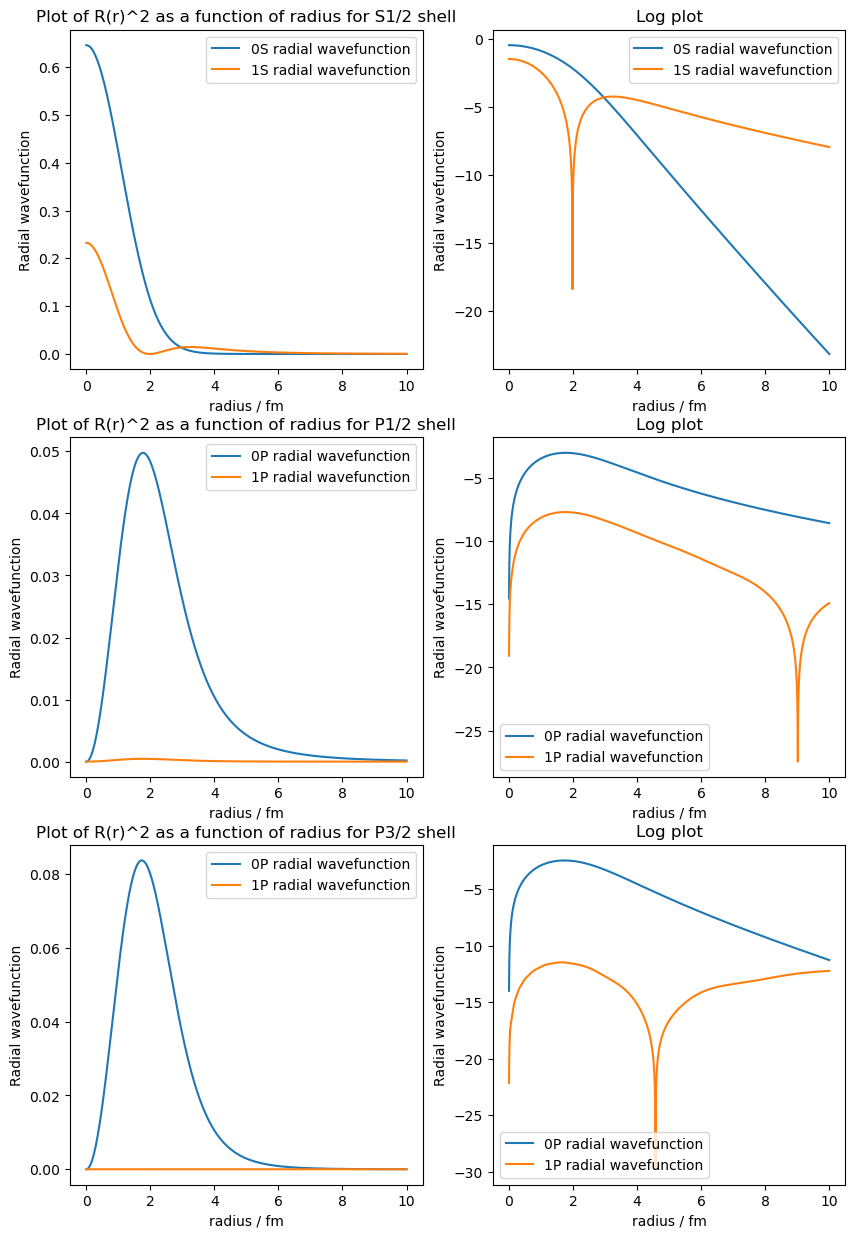

In [14]:
fig = plt.figure(figsize=(10,15))
spec = fig.add_gridspec(ncols=2, nrows=3)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])
ax_5 = fig.add_subplot(spec[2, 0])
ax_6 = fig.add_subplot(spec[2, 1])

x_values = np.linspace(0., 10, 3000)
#evaluated_ur_values = reduced_radial_wavefunction(x_values, ground_state_eigenvector, 0)[0]
#print(reduced_radial_wavefunction(x_values))

ax_1.set_title(f'Plot of R(r)^2 as a function of radius for S1/2 shell')
ax_1.set_xlabel('radius / fm')
ax_1.set_ylabel('Radial wavefunction')
ax_1.plot(x_values, radial_wavefunction(x_values, s0_eigenvector, 0), label="0S radial wavefunction")
ax_1.plot(x_values, radial_wavefunction(x_values, s1_eigenvector, 0), label="1S radial wavefunction")
ax_1.legend()

ax_2.set_title('Log plot')
ax_2.set_xlabel('radius / fm')
ax_2.set_ylabel('Radial wavefunction')
ax_2.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, s0_eigenvector, 0))), label="0S radial wavefunction")
ax_2.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, s1_eigenvector, 0))), label="1S radial wavefunction")
ax_2.legend()

ax_3.set_title(f'Plot of R(r)^2 as a function of radius for P1/2 shell')
ax_3.set_xlabel('radius / fm')
ax_3.set_ylabel('Radial wavefunction')
ax_3.plot(x_values, radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1), label="0P radial wavefunction")
ax_3.plot(x_values, radial_wavefunction(x_values, one_p_one_half_eigenvector, 1), label="1P radial wavefunction")
ax_3.legend()

ax_4.set_title('Log plot')
ax_4.set_xlabel('radius / fm')
ax_4.set_ylabel('Radial wavefunction')
ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1))), label="0P radial wavefunction")
ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_one_half_eigenvector, 1))), label="1P radial wavefunction")
ax_4.legend()

ax_5.set_title(f'Plot of R(r)^2 as a function of radius for P3/2 shell')
ax_5.set_xlabel('radius / fm')
ax_5.set_ylabel('Radial wavefunction')
ax_5.plot(x_values, radial_wavefunction(x_values, zero_p_three_half_eigenvector, 1), label="0P radial wavefunction")
ax_5.plot(x_values, radial_wavefunction(x_values, one_p_three_half_eigenvector, 1), label="1P radial wavefunction")
ax_5.legend()

ax_6.set_title('Log plot')
ax_6.set_xlabel('radius / fm')
ax_6.set_ylabel('Radial wavefunction')
ax_6.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_three_half_eigenvector, 1))), label="0P radial wavefunction")
ax_6.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_three_half_eigenvector, 1))), label="1P radial wavefunction")
ax_6.legend()

plt.savefig('s_state_plot.png', dpi=300)
plt.show()